# Digital Signal and Image Management - Face Recognition

Master's Degree in Data Science (A.Y. 2021/2022)

Autori: Silvia Ranieri, 
Raffaele Moretti,
Mattia Boller

# Libraries

In [ ]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
from keras.utils import np_utils

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from pickle import dump, load

## Load images and extract faces

In [ ]:
# Extract face from a photo
def face_extractor(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faceCascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
    detect_faces = faceCascade.detectMultiScale(gray, minSize=(30,30))
    if len(detect_faces)>0:
        # Find the face by looking at the size of detections (choose the largest one)
        # Sometimes opencv detect wrong faces and usually are smaller portion of the original image in respect to the true face
        face_index = np.argmax(detect_faces[:,2]) 
        x, y, w, h = detect_faces[face_index]
        face = image[y:y + h, x:x + w]
        resized_face = cv.resize(face, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
    return resized_face

In [ ]:
# Load photos and extract faces
def face_loader(dir='./'):
  faces = []
  labels = []
  for person in os.listdir(dir):
    for photo in os.listdir(dir + '/' + person):
      image = cv.imread((dir + '/' + person + '/' + photo))
      face = face_extractor(image)
      if len(face)>0:
        faces.append(face)
        labels.append(person)

  return faces, labels

In [ ]:
faces, labels = face_loader('./data/faces')

In [ ]:
# Encode the labels in a format usable in a NN
encoder = LabelEncoder()
labels_enc = encoder.fit_transform(labels)
y = np_utils.to_categorical(labels_enc, 3)

In [ ]:
dump(encoder, open('labelEncoder.pkl', 'wb'))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(faces, y, test_size=0.1, random_state=111)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

## Build the model

In [ ]:
# Load a pre-trained neural network to use for transfer learning
base_net = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

In [ ]:
# Set the layers of the base net to not be trained
for layer in base_net.layers:
  layer.trainable=False

In [ ]:
# Add to the MobileNetV2 some data augmentation layers and 2 dense layer to adapt the net to our problem
inputs = keras.Input(shape=(224,224,3))
x = inputs
### Data augmentation (active only during training (not during .evaluate() and .predict() calls))
x = keras.layers.RandomFlip("horizontal")(x)
x = keras.layers.RandomRotation(0.2, fill_mode="nearest")(x)
x = keras.layers.RandomZoom(0.6)(x)
x = keras.layers.RandomContrast(0.8)(x)
###
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_net(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(3, activation='softmax')(x)
outputs = x

In [ ]:
net = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
net.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Training and testing the model

In [ ]:
# Train the neural network
history = net.fit(x_train, y_train, batch_size=16, epochs=20, validation_split=0.1)

Epoch 1/20
5/5 [==============================] - 10s 818ms/step - loss: 1.5561 - accuracy: 0.3750 - val_loss: 1.2767 - val_accuracy: 0.2222
Epoch 2/20
5/5 [==============================] - 3s 638ms/step - loss: 0.7043 - accuracy: 0.6806 - val_loss: 0.4181 - val_accuracy: 0.8889
Epoch 3/20
5/5 [==============================] - 3s 597ms/step - loss: 0.4413 - accuracy: 0.8194 - val_loss: 0.4884 - val_accuracy: 0.7778
Epoch 4/20
5/5 [==============================] - 3s 644ms/step - loss: 0.3106 - accuracy: 0.8750 - val_loss: 0.1705 - val_accuracy: 0.8889
Epoch 5/20
5/5 [==============================] - 3s 592ms/step - loss: 0.2887 - accuracy: 0.9028 - val_loss: 0.1452 - val_accuracy: 1.0000
Epoch 6/20
5/5 [==============================] - 3s 639ms/step - loss: 0.2941 - accuracy: 0.9167 - val_loss: 0.1216 - val_accuracy: 1.0000
Epoch 7/20
5/5 [==============================] - 3s 598ms/step - loss: 0.1717 - accuracy: 0.9028 - val_loss: 0.1116 - val_accuracy: 1.0000
Epoch 8/20
5/5 [===

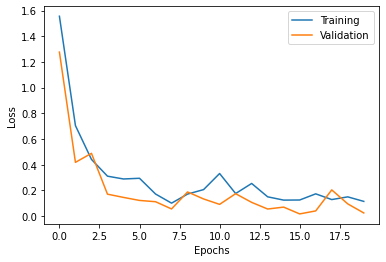

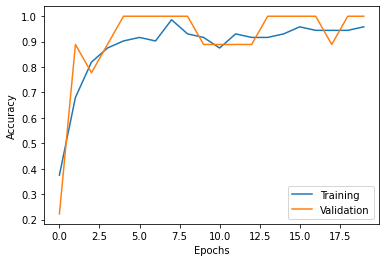

In [ ]:
# Plot training history
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(history)

# Evaluation

In [ ]:
pred = net.predict(x_test)
pred = np.argmax(pred, axis=1)
print(classification_report(encoder.inverse_transform(np.argmax(y_test, axis=1)), encoder.inverse_transform(pred)))

              precision    recall  f1-score   support

      Mattia       1.00      1.00      1.00         3
    Raffaele       1.00      1.00      1.00         4
      Silvia       1.00      1.00      1.00         2

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [ ]:
net.save('faceRecognitor.h5')

## Real-time face recognition

In [ ]:
encoder = load(open('labelEncoder.pkl', 'rb'))

In [ ]:
net = keras.models.load_model("faceRecognitor.h5")

In [ ]:
def detect_faces(image):
    # Load model to detect frontal faces
    face_detector = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, minNeighbors=4, scaleFactor=1.15, minSize=(100,100))
    img_bbx = image
    for (x,y,w,h) in faces:
        # Recognize faces
        face = image[y:y + h, x:x + w]
        resized_face = cv.resize(face, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
        pred = net.predict(np.expand_dims(resized_face, axis=0))
        index = np.argmax(pred, axis=1)
        person = encoder.inverse_transform(index)[0]
        prob = round(pred[0][index[0]]*100, 1)
        # If there is not enough certainty
        if prob < 70:
            person = 'Unknown'
        # Draw rectangles and put labels with confidence
        cv.rectangle(img_bbx,(x,y),(x+w,y+h),(0,255,0),2)
        cv.putText(img_bbx, person + ' ' + str(prob) + '%', (x+5,y-5), cv.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)
    return img_bbx

In [ ]:
# Start real-time face recognition
cap = cv.VideoCapture(0)
while(True):
    # Capture new frame
    r, frame = cap.read()
    # Process its content
    frame = detect_faces(frame)
    # Visualize (external window)
    cv.imshow('Video', frame)
    # Interrupt when Q key is pressed
    if cv.waitKey(20) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()